# 一、读取dicom文件的两种方式

## 1.使用pydicom读取dicom文件，这样读出来的image的size为(256, 256)，表示（高，宽）

In [6]:
import pydicom
import numpy as np
import torch
from matplotlib import pyplot as plt
from ./models/archs import NAFNET_arch
from ./models/archs import UnetModel_arch
from ./models/archs import UNetWaveletNet_arch

def read_dicom(file_path):
    dcm_data = pydicom.dcmread(file_path)            # 读取DICOM文件
    image = dcm_data.pixel_array.astype(np.float32)  # 将像素数据转换为float32类型
    # 特别注意，此时：image size: (256, 256)
    image = image.reshape(1, image.shape[0], image.shape[1]) # 给image增加第一维表示模态重复数=1，也可以是-1
#     image = image[np.newaxis, :, :]  # 给image增加第一维表示模态重复数=1，与上一语句等价
    lower_value = np.percentile(image, 0.05)
    upper_value = np.percentile(image, 99.5)
    image = np.clip(image, lower_value, upper_value)
    image = image / image.max()        # image size: (1, 256, 256)
    return image

patient = 'Patient2'
num = '11'
himgs = []
himg = read_dicom(f'./{patient}/FLAIR-Axial/ImageFileName{num}.dcm')
himgs.append(himg)
himg = read_dicom(f'./{patient}/T1WI-Axial/ImageFileName{num}.dcm')
himgs.append(himg)
himg = read_dicom(f'./{patient}/T2WI-Axial/ImageFileName{num}.dcm')
himgs.append(himg)
himg = read_dicom(f'./{patient}/T1WI-Sagittal/ImageFileName{num}.dcm')
himgs.append(himg)
himgs = np.stack(himgs,0)  # himgs: (4, 1, 256, 256),相当于himgs = np.array(himgs).reshape(4,1,256,256)

# np.stack([arrays1,array2,array3],axis=0)，将多个数组沿着新的维度axis堆叠成一个新数组。
# 对于单数组：axis=0，即沿着第1维堆叠
# 对于多数组：axis=0，即沿着第0维堆叠，此时把每个数组看成一个大元素，堆叠成一个新的大数组。
# 更深的总结：堆叠第二维时，即在某一确定第一维尺度i下，找第二维的值，并逐个堆叠。

torch_himg = torch.from_numpy(himgs)  # torch_himg size: torch.Size([4, 1, 256, 256])

# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(himg, cmap='gray')
# plt.title('original')
# plt.subplot(1, 2, 2)
# plt.imshow(torch_himg , cmap='gray')
# plt.title('normalized')
# plt.show()

SyntaxError: invalid syntax (1746327686.py, line 5)

轴位（横断位）：axial view

矢状位：sagittal view

华阴数据集中，每个就诊人员每个模式有0\~12共13张图，但注意，Patient3和4的T1WI-Sagittal只有0\~10共11张图，Patient5的T1WI-Sagittal只有0\~8共9张图！同时，这里的命名为ImageFileName1,2,3....，我将其重新命名为ImageFileName01,02,03....以确保和其他数据集命名方式一致。

# 二、载入模型文件

## 1. M4Raw的NAFNET网络

In [2]:
# NAFNET_arch.py
# ------------------------------------------------------------------------
# Copyright (c) 2022 megvii-model. All Rights Reserved.
# ------------------------------------------------------------------------

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class AvgPool2d(nn.Module):
    def __init__(self, kernel_size=None, base_size=None, auto_pad=True, fast_imp=False, train_size=None):
        super().__init__()
        self.kernel_size = kernel_size
        self.base_size = base_size
        self.auto_pad = auto_pad

        # only used for fast implementation
        self.fast_imp = fast_imp
        self.rs = [5, 4, 3, 2, 1]
        self.max_r1 = self.rs[0]
        self.max_r2 = self.rs[0]
        self.train_size = train_size

    def extra_repr(self) -> str:
        return 'kernel_size={}, base_size={}, stride={}, fast_imp={}'.format(
            self.kernel_size, self.base_size, self.kernel_size, self.fast_imp
        )

    def forward(self, x):
        if self.kernel_size is None and self.base_size:
            train_size = self.train_size
            if isinstance(self.base_size, int):
                self.base_size = (self.base_size, self.base_size)
            self.kernel_size = list(self.base_size)
            self.kernel_size[0] = x.shape[2] * self.base_size[0] // train_size[-2]
            self.kernel_size[1] = x.shape[3] * self.base_size[1] // train_size[-1]

            # only used for fast implementation
            self.max_r1 = max(1, self.rs[0] * x.shape[2] // train_size[-2])
            self.max_r2 = max(1, self.rs[0] * x.shape[3] // train_size[-1])

        if self.kernel_size[0] >= x.size(-2) and self.kernel_size[1] >= x.size(-1):
            return F.adaptive_avg_pool2d(x, 1)

        if self.fast_imp:  # Non-equivalent implementation but faster
            h, w = x.shape[2:]
            if self.kernel_size[0] >= h and self.kernel_size[1] >= w:
                out = F.adaptive_avg_pool2d(x, 1)
            else:
                r1 = [r for r in self.rs if h % r == 0][0]
                r2 = [r for r in self.rs if w % r == 0][0]
                # reduction_constraint
                r1 = min(self.max_r1, r1)
                r2 = min(self.max_r2, r2)
                s = x[:, :, ::r1, ::r2].cumsum(dim=-1).cumsum(dim=-2)
                n, c, h, w = s.shape
                k1, k2 = min(h - 1, self.kernel_size[0] // r1), min(w - 1, self.kernel_size[1] // r2)
                out = (s[:, :, :-k1, :-k2] - s[:, :, :-k1, k2:] - s[:, :, k1:, :-k2] + s[:, :, k1:, k2:]) / (k1 * k2)
                out = torch.nn.functional.interpolate(out, scale_factor=(r1, r2))
        else:
            n, c, h, w = x.shape
            s = x.cumsum(dim=-1).cumsum_(dim=-2)
            s = torch.nn.functional.pad(s, (1, 0, 1, 0))  # pad 0 for convenience
            k1, k2 = min(h, self.kernel_size[0]), min(w, self.kernel_size[1])
            s1, s2, s3, s4 = s[:, :, :-k1, :-k2], s[:, :, :-k1, k2:], s[:, :, k1:, :-k2], s[:, :, k1:, k2:]
            out = s4 + s1 - s2 - s3
            out = out / (k1 * k2)

        if self.auto_pad:
            n, c, h, w = x.shape
            _h, _w = out.shape[2:]
            # print(x.shape, self.kernel_size)
            pad2d = ((w - _w) // 2, (w - _w + 1) // 2, (h - _h) // 2, (h - _h + 1) // 2)
            out = torch.nn.functional.pad(out, pad2d, mode='replicate')

        return out

def replace_layers(model, base_size, train_size, fast_imp, **kwargs):
    for n, m in model.named_children():
        if len(list(m.children())) > 0:
            ## compound module, go inside it
            replace_layers(m, base_size, train_size, fast_imp, **kwargs)

        if isinstance(m, nn.AdaptiveAvgPool2d):
            pool = AvgPool2d(base_size=base_size, fast_imp=fast_imp, train_size=train_size)
            assert m.output_size == 1
            setattr(model, n, pool)

'''
ref. 
@article{chu2021tlsc,
  title={Revisiting Global Statistics Aggregation for Improving Image Restoration},
  author={Chu, Xiaojie and Chen, Liangyu and and Chen, Chengpeng and Lu, Xin},
  journal={arXiv preprint arXiv:2112.04491},
  year={2021}
}
'''
class Local_Base():
    def convert(self, *args, train_size, **kwargs):
        replace_layers(self, *args, train_size=train_size, **kwargs)
        imgs = torch.rand(train_size)
        with torch.no_grad():
            self.forward(imgs)
class LayerNormFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_variables
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)

    
# ------------------------------------------------------------------------
# Copyright (c) 2022 megvii-model. All Rights Reserved.
# ------------------------------------------------------------------------

'''
Simple Baselines for Image Restoration

@article{chen2022simple,
  title={Simple Baselines for Image Restoration},
  author={Chen, Liangyu and Chu, Xiaojie and Zhang, Xiangyu and Sun, Jian},
  journal={arXiv preprint arXiv:2204.04676},
  year={2022}
}
'''

import torch
import torch.nn as nn
import torch.nn.functional as F    

class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        
        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma


class NAFNET(nn.Module):
    def __init__(self,args=None, width=32, middle_blk_num=12, enc_blk_nums=[2, 2, 4, 8], dec_blk_nums=[2, 2, 2, 2]):
        super().__init__()
        self.args = args
        # in_nc = self.args.input_nc
        # out_nc = self.args.output_nc
        in_nc = 1
        out_nc = 1
        self.intro = nn.Conv2d(in_channels=in_nc, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=out_nc, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                nn.Conv2d(chan, 2*chan, 2, 2)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFBlock(chan) for _ in range(middle_blk_num)]
            )

        for num in dec_blk_nums:
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(chan, chan * 2, 1, bias=False),
                    nn.PixelShuffle(2)
                )
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp,gt=None):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x

class NAFNetLocal(Local_Base, NAFNET):
    def __init__(self, *args, train_size=(1, 3, 256, 256), fast_imp=False, **kwargs):
        Local_Base.__init__(self)
        NAFNet.__init__(self, *args, **kwargs)

        N, C, H, W = train_size
        base_size = (int(H * 1.5), int(W * 1.5))

        self.eval()
        with torch.no_grad():
            self.convert(base_size=base_size, train_size=train_size, fast_imp=fast_imp)


## 2. DlDegibbs网络

In [3]:
# utils.py
import numpy as np
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F


class roll_fftshift(nn.Module):
    def __init__(self, axis=0):
        super(roll_fftshift, self).__init__()
        self.axis = axis

    def forward(self, x):
        dim_size = x.size(self.axis)

        shift = dim_size//2

        after_start = dim_size - shift
        if shift < 0:
            after_start = -shift
            shift = dim_size - abs(shift)

        before = x.narrow(self.axis, 0, dim_size - shift)
        after = x.narrow(self.axis, after_start, shift)
        return torch.cat([after, before], self.axis)


class roll_ifftshift(nn.Module):
    def __init__(self, axis=0):
        super(roll_ifftshift, self).__init__()
        self.axis = axis

    def forward(self, x):
        dim_size = x.size(self.axis)

        shift = (dim_size+1)//2

        after_start = dim_size - shift
        if shift < 0:
            after_start = -shift
            shift = dim_size - abs(shift)

        before = x.narrow(self.axis, 0, dim_size - shift)
        after = x.narrow(self.axis, after_start, shift)
        return torch.cat([after, before], self.axis)


class fftshift(nn.Module):
    def __init__(self, ndims, startdim=2):
        super(fftshift, self).__init__()
        self.startdim = startdim
        self.ndims = ndims
        self.roll_list = nn.ModuleList()

        for dim in range(self.startdim, ndims):
            self.roll_list.append(roll_fftshift(axis=dim))

    def forward(self, x):
        for cur_roll in self.roll_list:
            x = cur_roll(x)
        return x


class ifftshift(nn.Module):
    def __init__(self, ndims, startdim=2):
        super(ifftshift, self).__init__()
        self.startdim = startdim
        self.ndims = ndims
        self.roll_list = nn.ModuleList()

        for dim in range(self.startdim, ndims):
            self.roll_list.append(roll_ifftshift(axis=dim))

    def forward(self, x):
        for cur_roll in self.roll_list:
            x = cur_roll(x)
        return x


class back_fft(nn.Module):
    def __init__(self, ndims, startdim=2):
        super(back_fft, self).__init__()
        self.ndims = ndims
        self.startdim = startdim
        self.ishift = ifftshift(ndims=ndims, startdim=startdim)
        self.fshift = fftshift(ndims=ndims, startdim=startdim)

    def forward(self, x):
        x = self.ishift(x)

        if (self.ndims == 4):
            x = x.permute(0, 2, 3, 1)
        elif (self.ndims == 5):
            x = x.permute(0, 2, 3, 4, 1)
        elif (self.ndims == 6):
            x = x.permute(0, 2, 3, 4, 5, 1)
        else:
            raise ValueError('ndim = %d not supported!' % self.ndims)

        x = torch.ifft(x, self.ndims - 2)

        if (self.ndims == 4):
            x = x.permute(0, 3, 1, 2)
        elif (self.ndims == 5):
            x = x.permute(0, 4, 1, 2, 3)
        elif (self.ndims == 6):
            x = x.permute(0, 2, 3, 4, 5, 1)
        else:
            raise ValueError('ndim = %d not supported!' % self.ndims)

        x = self.fshift(x)

        return x


class dwt2d(nn.Module):
    def __init__(self, channels=1, wtype='haar', levels=1):
        super(dwt2d, self).__init__()
        if wtype == 'haar':
            wt = pywt.Wavelet(wtype)
            dec_hi = torch.FloatTensor(wt.dec_hi[::-1])
            dec_lo = torch.FloatTensor(wt.dec_lo[::-1])
        else:
            print('filter type not found!')

        self.register_buffer(
            'filters',
            torch.stack(
                [
                    dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1),
                    dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1),
                    dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1),
                    dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)
                ] * channels
            ).unsqueeze(1)
        )

        self.channels = channels
        self.levels = levels

    def forward(self, x, levels=-1):
        if levels == -1:
            levels = self.levels

        h = x.size(2)
        w = x.size(3)
        x = torch.nn.functional.conv2d(
            x,
            self.filters,
            stride=2,
            groups=self.channels)

        if levels > 1:
            x[:, :1] = self.forward(x, levels-1)

        return x


class idwt2d(nn.Module):
    def __init__(self, channels=1, wtype='haar', levels=1, maxgroup=False):
        super(idwt2d, self).__init__()
        if wtype == 'haar':
            wt = pywt.Wavelet(wtype)
            rec_hi = torch.FloatTensor(wt.rec_hi)
            rec_lo = torch.FloatTensor(wt.rec_lo)
        else:
            print('filter type not found!')

        self.register_buffer(
            'inv_filters',
            torch.stack(
                [
                    rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                    rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                    rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                    rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)
                ] * channels
            ).unsqueeze(1)
        )

        self.maxgroup = maxgroup
        self.channels = channels
        self.levels = levels

    def forward(self, x, levels=-1):
        if levels == -1:
            levels = self.levels

        h = x.size(2)
        w = x.size(3)

        if levels > 1:
            x[:, :1] = self.forward(x, levels-1)

        if self.maxgroup:
            out_chans = self.inv_filters.shape[0]
        else:
            out_chans = self.channels

        x = torch.nn.functional.conv_transpose2d(
            x,
            self.inv_filters,
            stride=2,
            groups=out_chans)

        return x


In [4]:
# UNetWaveletNet_arch.py
import torch
import torch.nn as nn
import torch.nn.functional as F
class UNetWavelet(nn.Module):
    def __init__(self, nlayers=10, in_ch=1, out_ch=1, ndims=2, top_filtnum=64,
                 n_classes=False, resid=True, wave_concat=True, comp2mag=False,
                 leaky=False):
        super(UNetWavelet, self).__init__()

        if not ndims == 2:
            print('NOT TESTED FOR ANYTHING OTHER THAN 2D')

        self.ndims = ndims
        self.resid = resid
        self.wave_concat = wave_concat
        self.comp2mag = comp2mag
        self.leaky = leaky

        self.inconv = InConv(in_ch, top_filtnum, ndims=ndims, leaky=leaky)
        lastout = top_filtnum

        self.nlayers = nlayers

        self.downlayers = nn.ModuleList()
        self.wavedown = nn.ModuleList()
        for _ in range(0, (nlayers-2)//2-1):
            self.wavedown.append(dwt2d(channels=lastout))
            self.downlayers.append(
                DoubleConv(lastout, lastout*2, ndims=ndims, leaky=leaky)
            )
            lastout = lastout*2

        self.wavedown.append(dwt2d(channels=lastout))
        self.downlayers.append(MidConv(lastout, ndims=ndims, leaky=leaky))

        self.waveup = nn.ModuleList()
        self.uplayers = nn.ModuleList()
        for _ in range((nlayers-2)//2-1):
            if self.wave_concat is False:
                self.waveup.append(idwt2d(channels=lastout))
                self.uplayers.append(
                    ConcatDoubleConv(
                        lastout*2,
                        lastout//2,
                        ndims=ndims,
                        leaky=leaky
                    )
                )
            else:
                self.waveup.append(idwt2d(
                    channels=lastout, maxgroup=True))
                self.uplayers.append(
                    ConcatDoubleConv(
                        lastout*5,
                        lastout//2,
                        ndims=ndims,
                        leaky=leaky
                    )
                )
            lastout = lastout//2

        if self.wave_concat is False:
            self.waveup.append(idwt2d(channels=lastout))
            self.uplayers.append(
                ConcatDoubleConv(
                    lastout*2,
                    lastout,
                    ndims=ndims,
                    leaky=leaky
                )
            )
        else:
            self.waveup.append(idwt2d(channels=lastout, maxgroup=True))
            self.uplayers.append(
                ConcatDoubleConv(
                    lastout*5,
                    lastout,
                    ndims=ndims,
                    leaky=leaky
                )
            )
        lastout = lastout

        if n_classes:
            self.outlayer = OutConv(lastout, n_classes, ndims=ndims)
        else:
            self.outlayer = OutConv(lastout, out_ch, ndims=ndims)

    def forward(self, x):
        down_outputs = []
        wt_dec = []
        down_outputs.append(self.inconv(x))
        for i, curlayer in enumerate(self.downlayers):
            cur_wv = self.wavedown[i]
            wt_dec.append(cur_wv(down_outputs[i]))
            down_outputs.append(curlayer(wt_dec[i][:, :cur_wv.channels]))

        up_wt_rec = []
        up_outputs = []
        up_outputs.append(down_outputs[-1])

        for i, curlayer in enumerate(self.uplayers):
            cur_wv = self.waveup[i]
            if self.wave_concat is False:
                up_wt_rec.append(
                    cur_wv(
                        torch.cat(
                            (up_outputs[i],  wt_dec[-1+-1*i]
                             [:, cur_wv.channels:]),
                            1
                        )
                    )
                )
            else:
                cur_chan = up_outputs[i].shape[1]
                up_wt_rec.append(
                    cur_wv(
                        torch.cat(
                            (up_outputs[i], wt_dec[-1+-1*i][:, cur_chan:]),
                            1
                        )
                    )
                )

            up_outputs.append(curlayer(up_wt_rec[i], down_outputs[-2-i]))

        # apply the final output layer
        y = self.outlayer(up_outputs[-1])

        # residual skipped connection (considering partial Fourier channel)
        if self.resid:
            y = y + x[:, :2, ...]

        # magnitude operation
        if self.comp2mag:
            y = torch.sqrt(y[:, 0, ...]**2 + y[:, 1, ...]**2).unsqueeze(1)

        return y


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, mid_ch=-1, ndims=2, leaky=False):
        super(DoubleConv, self).__init__()

        if mid_ch == -1:
            mid_ch = out_ch
            self.mid_ch = out_ch

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.ndims = ndims
        self.leaky = leaky

        if (ndims == 2):
            if self.leaky:
                self.conv = nn.Sequential(
                    nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1),
                    nn.BatchNorm2d(mid_ch),
                    nn.LeakyReLU(inplace=True),
                    nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
                    nn.BatchNorm2d(out_ch),
                    nn.LeakyReLU(inplace=True)
                )
            else:
                self.conv = nn.Sequential(
                    nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1),
                    nn.BatchNorm2d(mid_ch),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True)
                )
        else:
            if self.leaky:
                self.conv = nn.Sequential(
                    nn.Conv3d(in_ch, mid_ch, kernel_size=3, padding=1),
                    nn.BatchNorm3d(mid_ch),
                    nn.LeakyReLU(inplace=True),
                    nn.Conv3d(mid_ch, out_ch, kernel_size=3, padding=1),
                    nn.BatchNorm3d(out_ch),
                    nn.LeakyReLU(inplace=True)
                )
            else:
                self.conv = nn.Sequential(
                    nn.Conv3d(in_ch, mid_ch, kernel_size=3, padding=1),
                    nn.BatchNorm3d(mid_ch),
                    nn.ReLU(inplace=True),
                    nn.Conv3d(mid_ch, out_ch, kernel_size=3, padding=1),
                    nn.BatchNorm3d(out_ch),
                    nn.ReLU(inplace=True)
                )

    def forward(self, x):
        x = self.conv(x)
        return x


class MidConv(nn.Module):
    def __init__(self, in_ch, ndims=2, leaky=False):
        super(MidConv, self).__init__()

        self.in_ch = in_ch
        self.ndims = ndims
        self.leaky = leaky

        self.ndims = ndims
        if (ndims == 2):
            if self.leaky:
                self.conv = nn.Sequential(
                    nn.Conv2d(in_ch, in_ch*2, kernel_size=3, padding=1),
                    nn.BatchNorm2d(in_ch*2),
                    nn.LeakyReLU(inplace=True),
                    nn.Conv2d(in_ch*2, in_ch, kernel_size=3, padding=1),
                    nn.BatchNorm2d(in_ch),
                    nn.LeakyReLU(inplace=True)
                )
            else:
                self.conv = nn.Sequential(
                    nn.Conv2d(in_ch, in_ch*2, kernel_size=3, padding=1),
                    nn.BatchNorm2d(in_ch*2),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_ch*2, in_ch, kernel_size=3, padding=1),
                    nn.BatchNorm2d(in_ch),
                    nn.ReLU(inplace=True)
                )
        else:
            if self.leaky:
                self.conv = nn.Sequential(
                    nn.Conv3d(in_ch, in_ch*2, kernel_size=3, padding=1),
                    nn.BatchNorm3d(in_ch*2),
                    nn.LeakyReLU(inplace=True),
                    nn.Conv3d(in_ch*2, in_ch, kernel_size=3, padding=1),
                    nn.BatchNorm3d(in_ch),
                    nn.LeakyReLU(inplace=True)
                )
            else:
                self.conv = nn.Sequential(
                    nn.Conv3d(in_ch, in_ch*2, kernel_size=3, padding=1),
                    nn.BatchNorm3d(in_ch*2),
                    nn.ReLU(inplace=True),
                    nn.Conv3d(in_ch*2, in_ch, kernel_size=3, padding=1),
                    nn.BatchNorm3d(in_ch),
                    nn.ReLU(inplace=True)
                )

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch, ndims=2, leaky=False):
        super(InConv, self).__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.ndims = ndims
        self.leaky = leaky

        if (ndims == 2):
            if self.leaky:
                self.conv = nn.Sequential(
                    nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                    nn.BatchNorm2d(out_ch),
                    nn.LeakyReLU(inplace=True),
                    DoubleConv(out_ch, out_ch, ndims=ndims, leaky=self.leaky)
                )
            else:
                self.conv = nn.Sequential(
                    nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True),
                    DoubleConv(out_ch, out_ch, ndims=ndims, leaky=self.leaky)
                )
        else:
            if self.leaky:
                self.conv = nn.Sequential(
                    nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
                    nn.BatchNorm3d(out_ch),
                    nn.LeakyReLU(inplace=True),
                    DoubleConv(out_ch, out_ch, ndims=ndims, leaky=self.leaky)
                )
            else:
                self.conv = nn.Sequential(
                    nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
                    nn.BatchNorm3d(out_ch),
                    nn.ReLU(inplace=True),
                    DoubleConv(out_ch, out_ch, ndims=ndims, leaky=self.leaky)
                )

    def forward(self, x):
        y = self.conv(x)
        return y


class DownConv(nn.Module):
    def __init__(self, in_ch, out_ch, ndims=2, leaky=False):
        super(DownConv, self).__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.ndims = ndims
        self.leaky = leaky

        if (ndims == 2):
            self.mpconv = nn.Sequential(
                nn.MaxPool2d(kernel_size=2),
                DoubleConv(in_ch, out_ch, ndims=ndims, leaky=self.leaky)
            )
        else:
            self.mpconv = nn.Sequential(
                nn.MaxPool3d(kernel_size=2),
                DoubleConv(in_ch, out_ch, ndims=ndims, leaky=self.leaky)
            )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class ConcatDoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, ndims=2, leaky=False):
        super(ConcatDoubleConv, self).__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.ndims = ndims
        self.leaky = leaky

        self.conv = DoubleConv(
            in_ch,
            out_ch,
            mid_ch=out_ch*2,
            ndims=ndims,
            leaky=self.leaky
        )

    def forward(self, x1, x2):
        diffX = x2.size()[3] - x1.size()[3]
        diffY = x2.size()[2] - x1.size()[2]
        #x1 = F.upsample(x1, size=x2.size())
        x1 = F.pad(x1, (diffX // 2, int(diffX / 2) + diffX % 2,
                        diffY // 2, int(diffY / 2) + diffY % 2), mode='constant')
        x = torch.cat([x2, x1], dim=1)

        x = self.conv(x)

        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch, ndims=2):
        super(OutConv, self).__init__()

        self.ndims = ndims
        if (ndims == 2):
            self.conv = nn.Conv2d(
                in_ch,
                out_ch,
                kernel_size=1,
                padding=0,
                groups=1
            )
        else:
            self.conv = nn.Conv3d(
                in_ch,
                out_ch,
                kernel_size=1,
                padding=0,
                groups=1
            )

    def forward(self, x):
        x = self.conv(x)

        return x

## 3.FastMRI的Unet网络

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, relu activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob, variant=None, ks=3, pad=1, dil=1, num_group=1):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
            variant (string): Variant of Convolutional Block ('dense', 'res', or None).
            ks (int): Kernel size.
            pad (int): Padding.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans1 = out_chans
        self.out_chans2 = out_chans
        self.drop_prob = drop_prob
        self.variant = variant

        if variant == 'dense':
            self.out_chans1 = out_chans//2
            self.out_chans2 = out_chans - out_chans//2
        elif variant == 'res':
            self.out_chans2 = out_chans - min(in_chans, out_chans//2)

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_chans, self.out_chans1, kernel_size=ks, padding=pad, dilation=dil, groups=num_group),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(self.out_chans1, self.out_chans2, kernel_size=ks, padding=pad, dilation=dil, groups=num_group),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        x1 = self.layer1(input)
        x2 = self.layer2(x1)

        if self.variant == 'dense':
            return torch.cat((x2, x1), 1)
        elif self.variant == 'res':
            return torch.cat((x2, input[:, :min(self.in_chans, self.out_chans1//2)]), 1)
        else:
            return x2

    def __repr__(self):
        return f'ConvBlock(in_chans={self.in_chans}, out_chans1={self.out_chans1}, out_chans2={self.out_chans2} ' \
               f'drop_prob={self.drop_prob}, variant={self.variant})'


class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.

    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, args=None, variant=None, kernel_size=3, padding=1, dilation=1, groups=1):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super(UnetModel, self).__init__()

        in_chans = 1
        out_chans = 1
        chans = 256

        num_pool_layers = 4
        drop_prob = 0.0

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob, variant=variant, ks=kernel_size, pad=padding, dil=dilation, num_group=groups)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob, variant=variant, ks=kernel_size, pad=padding, dil=dilation, num_group=groups)]
            ch *= 2
        self.conv = ConvBlock(ch, ch, drop_prob, variant=variant, ks=kernel_size, pad=padding, dil=dilation, num_group=groups)

        self.up_sample_layers = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob, variant=variant, ks=kernel_size, pad=padding, dil=dilation, num_group=groups)]
            ch //= 2
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob, variant=variant, ks=kernel_size, pad=padding, dil=dilation, num_group=groups)]
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input, *args):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]

        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.up_sample_layers:
            downsample_layer = stack.pop()
            layer_size = (downsample_layer.shape[-2], downsample_layer.shape[-1])
            output = F.interpolate(output, size=layer_size, mode='bilinear', align_corners=False)
            output = torch.cat([output, downsample_layer], dim=1)
            output = layer(output)

        return self.conv2(output)


class Push(nn.Module):
    pass


class Pop(nn.Module):
    pass


def conv(in_channels, out_channels, transpose=False, kernel_size=3):
    if transpose:
        yield nn.ConvTranspose2d(in_channels, out_channels, 2, 2, bias=False)
    else:
        yield nn.Conv2d(in_channels, out_channels, kernel_size, 1, kernel_size // 2, bias=False)
    yield nn.InstanceNorm2d(out_channels)
    yield nn.LeakyReLU(0.2, True)


class UnetModel2(nn.Module):
    def __init__(self, args = None):
        super().__init__()
        
        in_chans = args.in_chans
        out_chans = args.out_chans
        chans = args.chans
        c = chans
        self.layers = nn.ModuleList([
            *conv(in_chans, 1 * c), *conv(1 * c, 1 * c), Push(), nn.AvgPool2d(2, 2),
            *conv(1 * c, 2 * c), *conv(2 * c, 2 * c), Push(), nn.AvgPool2d(2, 2),
            *conv(2 * c, 4 * c), *conv(4 * c, 4 * c), Push(), nn.AvgPool2d(2, 2),
            *conv(4 * c, 8 * c), *conv(8 * c, 8 * c), Push(), nn.AvgPool2d(2, 2),
            *conv(8 * c, 16 * c), *conv(16 * c, 16 * c), *conv(16 * c, 8 * c, transpose=True), Pop(),
            *conv(16 * c, 8 * c), *conv(8 * c, 8 * c), *conv(8 * c, 4 * c, transpose=True), Pop(),
            *conv(8 * c, 4 * c), *conv(4 * c, 4 * c), *conv(4 * c, 2 * c, transpose=True), Pop(),
            *conv(4 * c, 2 * c), *conv(2 * c, 2 * c), *conv(2 * c, 1 * c, transpose=True), Pop(),
            *conv(2 * c, 1 * c), *conv(1 * c, 1 * c), nn.Conv2d(1 * c, out_chans, 1),
        ])

    def forward(self, input, *args):
        self.stack = []
        x = input
        for lyr in self.layers:
            if isinstance(lyr, Push):
                self.stack.append(x)
            elif isinstance(lyr, Pop):
                x = torch.cat([x, self.stack.pop()], dim=1)
            else:
                x = lyr(x)
        return x


def unet(args):
    return UnetModel(
        in_chans=1,
        out_chans=1,
        chans=args.num_chans,
        num_pool_layers=args.num_pools,
        drop_prob=args.drop_prob)


# 三、创建模型并加载已训练好的模型参数

## 1.Nafnet（论文）

In [14]:
import time # 计时
start_time1 = time.time()
model = NAFNET(None)
checkpoint = torch.load('../paper_pth/M4Raw_Denoising_NAFNET.pth',map_location='cpu')
model.load_state_dict(checkpoint)
model = model.eval().cuda()
with torch.no_grad():
    out = model(torch_himg.cuda()).cpu()    # Nafnet_paper
end_time1 = time.time()
print("Nafnet(M4Raw_V1.0)处理时间：", end_time1 - start_time1, "秒")

Nafnet(M4Raw_V1.0)处理时间： 0.5563943386077881 秒


## 2.Nafnet（重新训练）

In [24]:
start_time2 = time.time()
model1 = NAFNET(None)
checkpoint1 = torch.load('F:/M4RawV1.5_experiment/random_init_NAFNET_all_lr1e4/snapshot/net_40.pth',map_location='cpu')
model1.load_state_dict(checkpoint1)
model1 = model1.eval().cuda()
with torch.no_grad():
    out1 = model1(torch_himg.cuda()).cpu()  # Nafnet_self
end_time2 = time.time()
print("Nafnet(M4Raw_V1.5)处理时间：", end_time2 - start_time2, "秒")

Nafnet(M4Raw_V1.5)处理时间： 0.5623903274536133 秒


## 3.UNetWavelet

In [28]:
start_time3 = time.time()
model2 = UNetWavelet(nlayers=13)
# checkpoint2 = torch.load('F:/DlDegibbs_experiment/random_init_UNetWaveletNet_all_batch16_layer13_lr1e4/snapshot/net_30.pth',map_location='cpu')
checkpoint2 = torch.load('F:/DlDegibbs_experiment/random_init_UNetWaveletNet_all_nlayers12_batch16/snapshot/net_30.pth',map_location='cpu')
model2.load_state_dict(checkpoint2)
model2 = model2.eval().cuda()
with torch.no_grad():
    out2 = model2(torch_himg.cuda()).cpu()  # UNetWavelet
end_time3 = time.time()
print("UNetWavelet处理时间：", end_time3 - start_time3, "秒")

UNetWavelet处理时间： 1.4304585456848145 秒


## 4.FastMRI的Unet网络

In [29]:
start_time4 = time.time()
model3 = UnetModel(None)
checkpoint3 = torch.load('F:/Fastmri_experiment/random_init_UnetModel_all_batch8/snapshot/net_40.pth',map_location='cpu')
model3.load_state_dict(checkpoint3)
model3 = model3.eval().cuda()
with torch.no_grad():
    out3 = model3(torch_himg.cuda()).cpu()  # FastMRI_Unet
end_time4 = time.time()
print("FastMRI Unet处理时间：", end_time4 - start_time4, "秒")

FastMRI Unet处理时间： 3.264479637145996 秒


In [26]:
import bm3d
start_time5 = time.time()
bm3d_outputs = []
for i in range(4):
    sigma = himgs[i][0][:50,:50].std() * 1.5
    bm3d_outputs.append(bm3d.bm3d(himgs[i][0],sigma))
end_time5 = time.time()
print("BM3D处理时间：", end_time5 - start_time5, "秒")

BM3D处理时间： 3.6050989627838135 秒


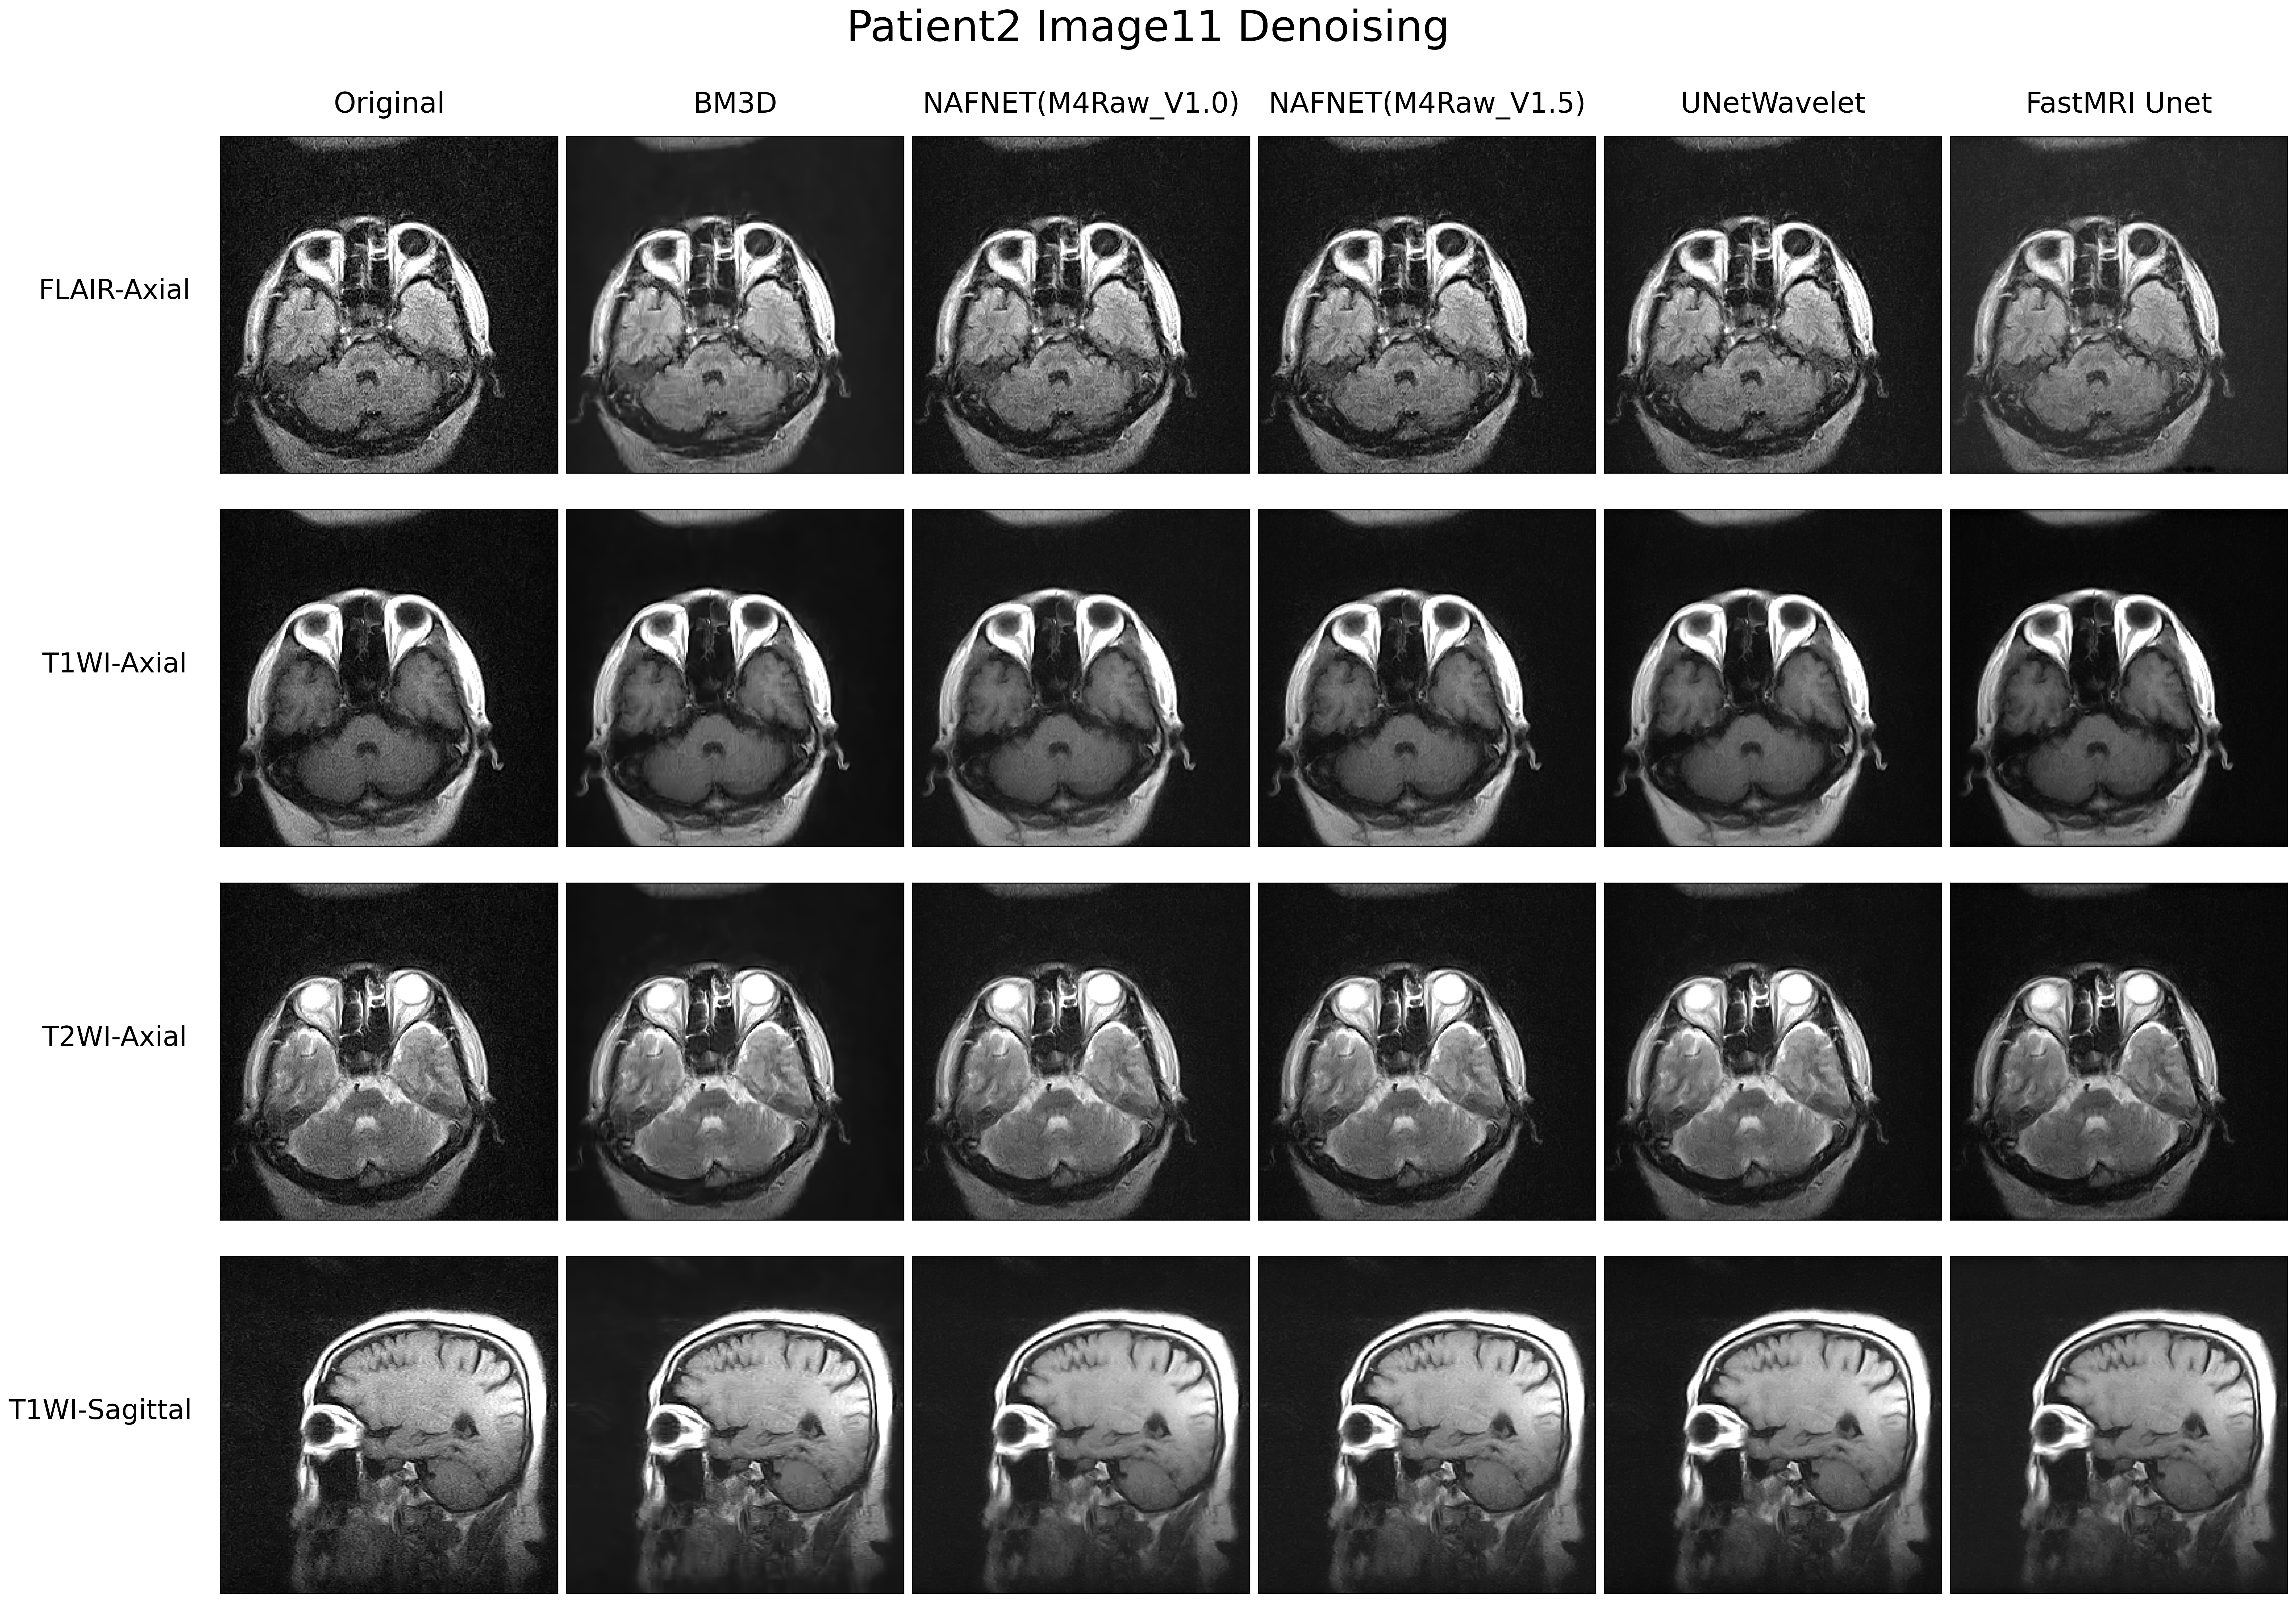

In [30]:
mode_num = 4   # 共有T1、T2、FLAIR轴位和T1矢状位4种扫描方式
algo_num = 6   # 共有1组原图和5种算法
plt.figure(figsize=(27,19),dpi=300)
plt.suptitle(f'{patient} Image{num} Denoising', fontsize=36,y = 1)
for i in range(1, mode_num+1):      # 由于有4种扫描方式，故遍历4行，i从1到4
    if i == 1:
        vmax = 0.81  # 设置图像显示时的颜色映射的最大值。图像中像素的数值≥vmax的部分将被映射为颜色映射的最高颜色
    if i == 2:
        vmax = 0.71
    if i == 3:
        vmax = 0.83  
    if i == 4:
        vmax = 0.5
    for j in range(1, algo_num+1):  # 现在有n=4种算法，每一种算法放置于每一列
        pos = j+(i-1)*algo_num      # 表位置[i][j]对应第pos个位置（行优先）
        plt.subplot(mode_num, algo_num, pos) # 创建位置[i][j]对应的子图
        if j == 1:   # 当前位置处于为第1列，为原图
            if i == 1:
                plt.title('Original', fontsize=24, pad=20)
                plt.ylabel("FLAIR-Axial", fontsize=23, labelpad=86, rotation=360) # 字体24，与y轴相距82，旋转360
            elif i == 2:
                plt.ylabel("T1WI-Axial", fontsize=23, labelpad=86, rotation=360)
            elif i == 3:
                plt.ylabel("T2WI-Axial", fontsize=23, labelpad=86, rotation=360)
            elif i == 4:
                plt.ylabel("T1WI-Sagittal", fontsize=23, labelpad=98, rotation=360)
            plt.imshow(himgs[i-1][0],cmap='gray',vmax=vmax)      # Original
        elif j == 2:   # 第2列：BM3D
            if i == 1:
                plt.title('BM3D', fontsize=24, pad=20)
            plt.imshow(bm3d_outputs[i-1],cmap='gray',vmax=vmax)  # BM3D
        elif j == 3:   # 第3列：paper的NAFNET
            if i == 1:
                plt.title('NAFNET(M4Raw_V1.0)', fontsize=24, pad=20)
            plt.imshow(out[i-1][0],cmap='gray',vmax=vmax)        # M4Raw_NAFNET_paper
        elif j == 4:  # 第4列：自训练的Nafnet
            if i == 1:
                plt.title('NAFNET(M4Raw_V1.5)', fontsize=24, pad=20)
            plt.imshow(out1[i-1][0],cmap='gray',vmax=vmax)      # M4Raw_NAFNET_Self
        elif j == 5:  # 第5列:小波Unet
            if i == 1:
                plt.title('UNetWavelet', fontsize=24, pad=20)
            plt.imshow(out2[i-1][0],cmap='gray',vmax=vmax)      # UNetWavelet
        elif j == 6:  # 第6列:FastMRI_Unet
            if i == 1:
                plt.title('FastMRI Unet', fontsize=24, pad=20)
            plt.imshow(out3[i-1][0],cmap='gray',vmax=vmax)      # FastMRI Unet
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])   # 隐藏x轴
        ax.axes.yaxis.set_ticks([])   # 隐藏y轴

plt.tight_layout(h_pad=0.1,w_pad=0.4)